# Imports & utilities

In [72]:
import sys ; sys.path.append('..')
import automated_design, rrtd, generate, prior_envs, depth_limited_dfs_analytic, search_algorithms
import numpy as np
import random
import collections
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
def write_config(json_output):
    import os, json
    fn = os.getenv('HOME')+'/pu/cocosci-optdisco/static/optdisco/js/configuration/configuration.js'
    with open(fn, 'w') as f:
        f.write(f'export default {json.dumps(json_output)};')

# Utilities to generate configuration

In [75]:
def generate_experiment_config_for_graph(mdp, *, raise_overlap=True, random=random):
    # We choose a task distribution.
    D = rrtd.floyd_warshall(mdp)
    tasks_including_practice = [
        dict(start=s, goal=g, optimal_cost=D[s, g])
        for s in mdp.state_list
        for g in mdp.state_list
        if s != g
    ]
    tasks = [t for t in tasks_including_practice if t['optimal_cost'] != 1]

    # Picking some practice tasks
    practice_tasks_len1 = [t for t in tasks_including_practice if t['optimal_cost'] == 1]
    practice_tasks_len2 = [t for t in tasks_including_practice if t['optimal_cost'] == 2]

    probe_tasks = [(t['start'], t['goal']) for t in tasks if t['optimal_cost'] >= 3]

    print(f'Counts: {len(tasks)} tasks, {len(probe_tasks)} probe tasks')

    res = dict(
        adjacency=[[state, succ] for state, succ in mdp.adjacency.items()],
        ordering=[],
    )
    for _ in range(2):
        probes = [dict(start=s, goal=g) for s, g in generate.block_rand(probe_tasks, 10, random=random)]
        res['ordering'].append(dict(
            navigation_practice_len1=[dict(t, practice=True) for t in generate.block_rand(practice_tasks_len1, 2, random=random)],
            navigation_practice_len2=[dict(t, practice=True) for t in generate.block_rand(practice_tasks_len2, 2, random=random)],
            navigation=generate.block_rand(tasks, 30, random=random),
            probes_solway2014=probes,
            probes_subgoal=generate.shuffled(probes, random=random),
        ))
        assert len(res['ordering'][-1]['probes_solway2014']) == 10
        assert len(res['ordering'][-1]['probes_subgoal']) == 10

    # We also append the reverse of each set of orderings.
    res['ordering'] += [
        {k: v[::-1] for k, v in o.items()}
        for o in list(res['ordering'])
    ]

    return dict(
        res=res,
    )

c = generate_experiment_config_for_graph(prior_envs.f2c, raise_overlap=False, random=random.Random(42))
c2 = generate_experiment_config_for_graph(prior_envs.f2c, raise_overlap=False, random=random.Random(42))
assert c == c2, 'Making sure randomness is all accounted for.'

Counts: 60 tasks, 40 probe tasks
Counts: 60 tasks, 40 probe tasks


In [76]:
def generate_experiment_config_for_graphs(mdps, *, random=random, debug=False):
    icons = [
        '🎈','🎀','🎁','📌','✏️','🔮','💰','⚙️','💎','💡','⏰',
        '✈️','🍫','🍎','🧀','🍪','🌞','⛄️','🐒','👑','👟','🤖','🤡',
    ]

    mdp_configs = [
        generate_experiment_config_for_graph(mdp, random=random)['res']
        for mdp in mdps
    ]

    num_states = len(mdps[0].state_list)
    for mdp in mdps:
        assert len(mdp.state_list) == num_states

    embedding = []
    for _ in range(4):
        order = generate.shuffled(range(num_states), random=random)
        embedding.append(dict(
            type='circle',
            order=order,
            coordinates=[generate.coordinates_for_circle_order(o) for o in generate.allrotflip(order)],
        ))

    json_output = dict(
        graph=mdp_configs,
        icons=[
            random.sample(icons, num_states)
            for _ in range(10)
        ],
        embedding=embedding,
    )

    total = len(mdps) * 32
    print(f'Total participants: {total}')

    ctf = json_output['conditionToFactors'] = generate.sample_factor_assignment(json_output, counterbalance=[
        'graph',
        'graph.ordering',
        'embedding',
    ], sample=[
        'icons',
        'embedding.coordinates', # this is a sampled rot/flip
    ], count=total, random=random)

    print(f'Should be configured to have {len(list(ctf.values())[0])} participants')

    if debug:
        print(collections.Counter(
            zip(*[json_output['conditionToFactors'][k] for k in ['graph', 'graph.ordering', 'embedding']])
        ))

    return json_output

mdp = automated_design.parse_g6('GCQRUw')
c = generate_experiment_config_for_graphs([mdp], random=random.Random(42), debug=True)
c2 = generate_experiment_config_for_graphs([mdp], random=random.Random(42), debug=True)
assert c == c2, 'Making sure randomness is all accounted for.'

for e in c['embedding']:
    poss = e['coordinates']
    rrtd.display_graphs([
        rrtd.plot_graph(mdp, pos=p, constant_node_size=0.05, z=range(8)) for p in poss
    ], columns=len(poss)/2)

Counts: 32 tasks, 14 probe tasks
Total participants: 32
Should be configured to have 32 participants
Counter({(0, 0, 2): 2, (0, 1, 1): 2, (0, 2, 2): 2, (0, 1, 0): 2, (0, 1, 2): 2, (0, 3, 3): 2, (0, 2, 3): 2, (0, 0, 0): 2, (0, 3, 1): 2, (0, 0, 3): 2, (0, 3, 0): 2, (0, 2, 1): 2, (0, 3, 2): 2, (0, 1, 3): 2, (0, 0, 1): 2, (0, 2, 0): 2})
Counts: 32 tasks, 14 probe tasks
Total participants: 32
Should be configured to have 32 participants
Counter({(0, 0, 2): 2, (0, 1, 1): 2, (0, 2, 2): 2, (0, 1, 0): 2, (0, 1, 2): 2, (0, 3, 3): 2, (0, 2, 3): 2, (0, 0, 0): 2, (0, 3, 1): 2, (0, 0, 3): 2, (0, 3, 0): 2, (0, 2, 1): 2, (0, 3, 2): 2, (0, 1, 3): 2, (0, 0, 1): 2, (0, 2, 0): 2})


<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg P

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg P

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg P

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg P

# Generating experiment config

In [77]:
def count_paths_gteq_len(mdp, *, length=None):
    dists = rrtd.floyd_warshall(mdp)
    return np.sum(dists>=length)

full_list = [
    mdp
    for mdp in automated_design.download_bdm_graphs_8c()
    if count_paths_gteq_len(mdp, length=3)>=10
]
print(f'full list of graphs length {len(full_list)}')
graph_list = random.Random(756653951).sample(full_list, k=30)
rrtd.display_graphs([rrtd.plot_graph(g) for g in graph_list], columns=6, html=False)

full list of graphs length 1676


In [78]:
# Command for the svg in the pre-reg
rrtd.display_graphs([
    rrtd.plot_graph(
        g,
        pos=generate.normalized_xy_coords(generate.svd_coordinates(generate.graphviz_coordinates(g, layout='neato'))),
        node_scaling=(0.07,0.07),
        node_arg=dict(fillcolor='white', penwidth="0.6"),
        edge_arg=dict(penwidth='0.6'),
    )
    for g in graph_list], columns=5, html=False, cellheight=80, cellwidth=90, cellpadding=10)

seed 792828651
Counts: 30 tasks, 10 probe tasks
Counts: 34 tasks, 10 probe tasks
Counts: 36 tasks, 14 probe tasks
Counts: 32 tasks, 10 probe tasks
Counts: 36 tasks, 12 probe tasks
Counts: 28 tasks, 12 probe tasks
Counts: 38 tasks, 16 probe tasks
Counts: 34 tasks, 12 probe tasks
Counts: 30 tasks, 10 probe tasks
Counts: 34 tasks, 12 probe tasks
Counts: 32 tasks, 10 probe tasks
Counts: 36 tasks, 12 probe tasks
Counts: 34 tasks, 12 probe tasks
Counts: 34 tasks, 14 probe tasks
Counts: 34 tasks, 12 probe tasks
Counts: 42 tasks, 26 probe tasks
Counts: 34 tasks, 10 probe tasks
Counts: 36 tasks, 10 probe tasks
Counts: 36 tasks, 10 probe tasks
Counts: 38 tasks, 18 probe tasks
Counts: 28 tasks, 10 probe tasks
Counts: 32 tasks, 12 probe tasks
Counts: 36 tasks, 20 probe tasks
Counts: 34 tasks, 18 probe tasks
Counts: 36 tasks, 22 probe tasks
Counts: 34 tasks, 12 probe tasks
Counts: 30 tasks, 12 probe tasks
Counts: 36 tasks, 14 probe tasks
Counts: 34 tasks, 12 probe tasks
Counts: 34 tasks, 14 probe t

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->

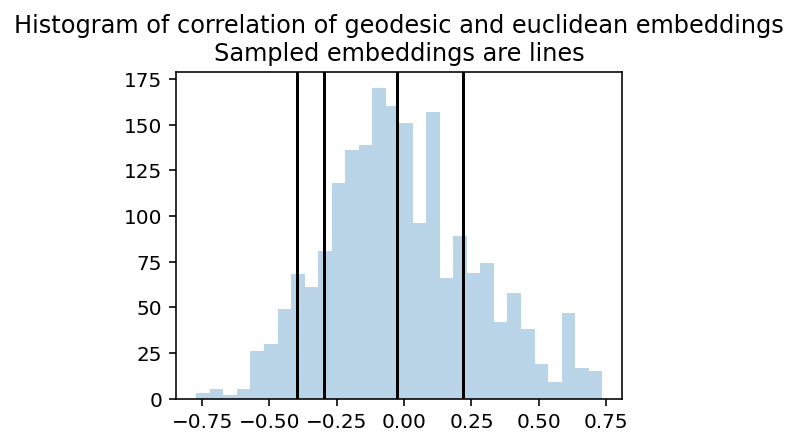

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6

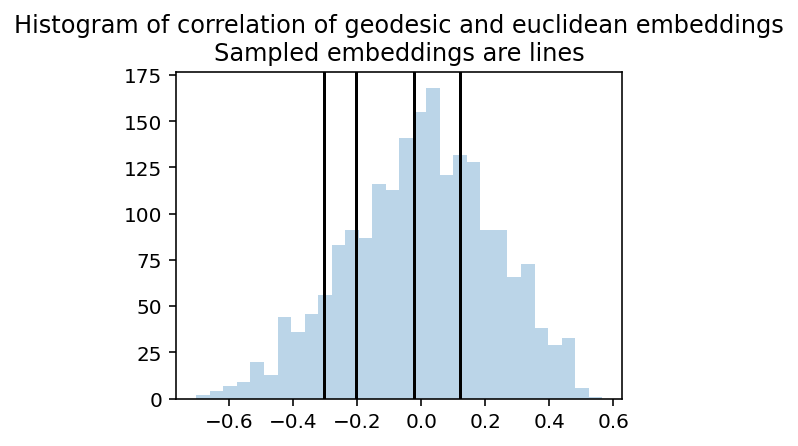

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6

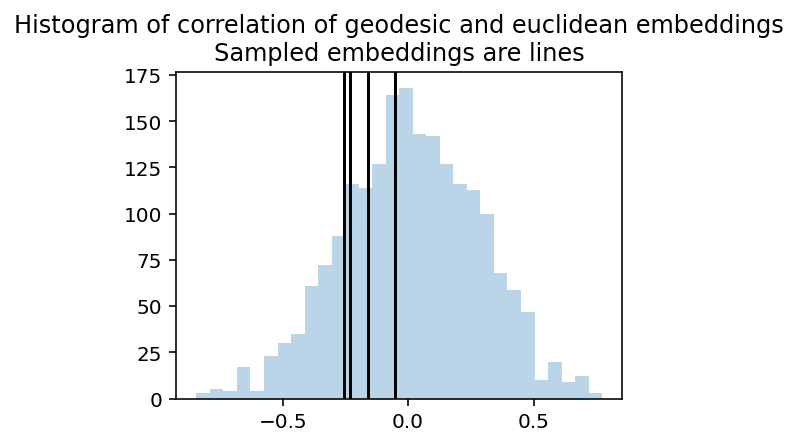

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7

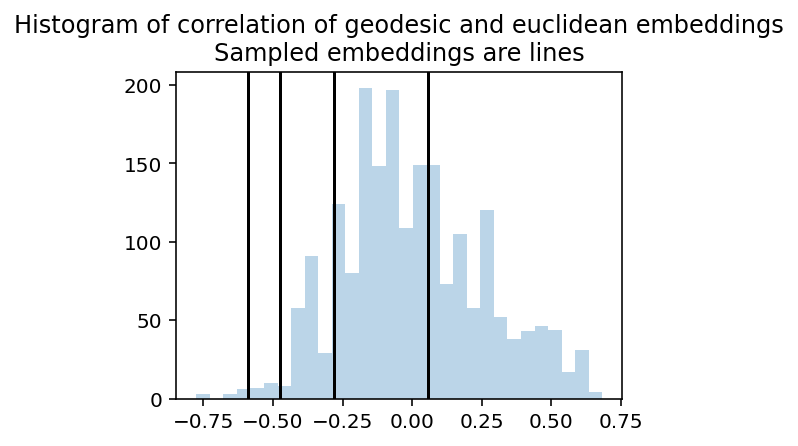

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 5->6 -->
 
 5->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 5->6 -->
 
 5->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 5->6 -->
 
 5->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 5->6 -->
 
 5->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 5->6 -->
 
 5->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 3->7 -->
 
 3->7

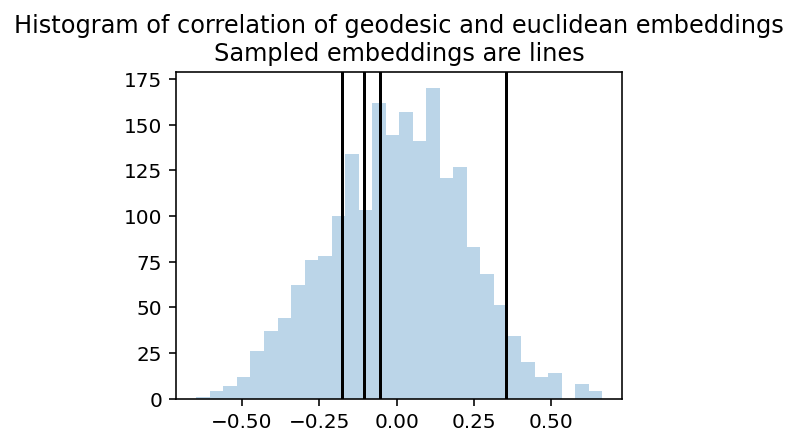

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4->5 -->
 
 4->5 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->4 -->
 
 2->4 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4->5 -->
 
 4->5 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->4 -->
 
 2->4 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4->5 -->
 
 4->5 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->4 -->
 
 2->4 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4->5 -->
 
 4->5 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->4 -->
 
 2->4 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4->5 -->
 
 4->

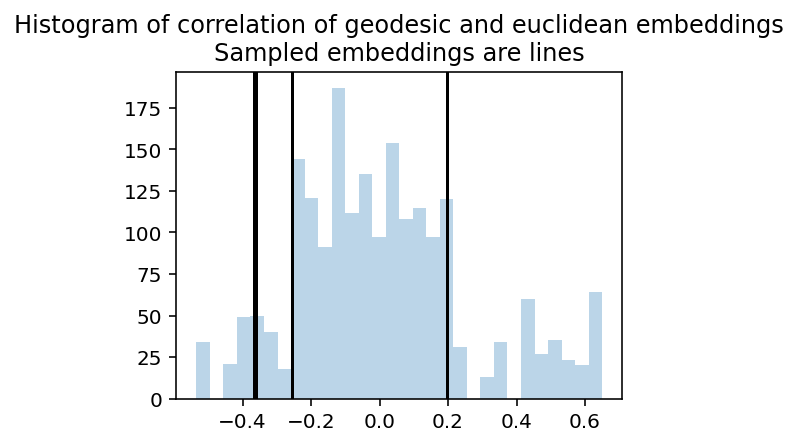

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7

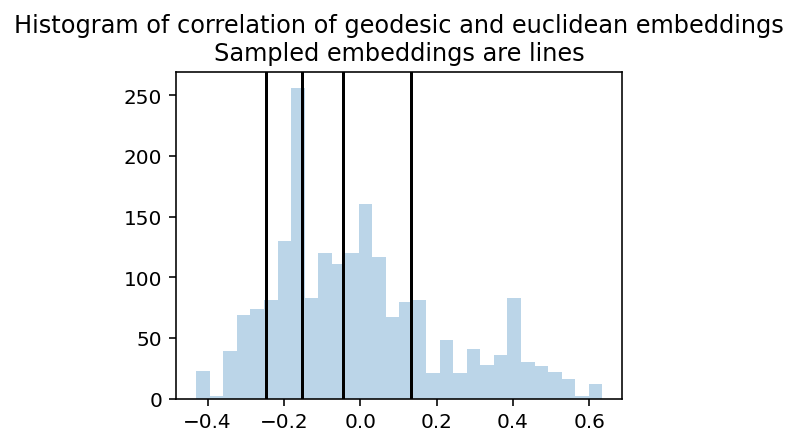

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 5->6 -->
 
 5->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 5->6 -->
 
 5->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 5->6 -->
 
 5->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 5->6 -->
 
 5->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 5->6 -->
 
 5->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7

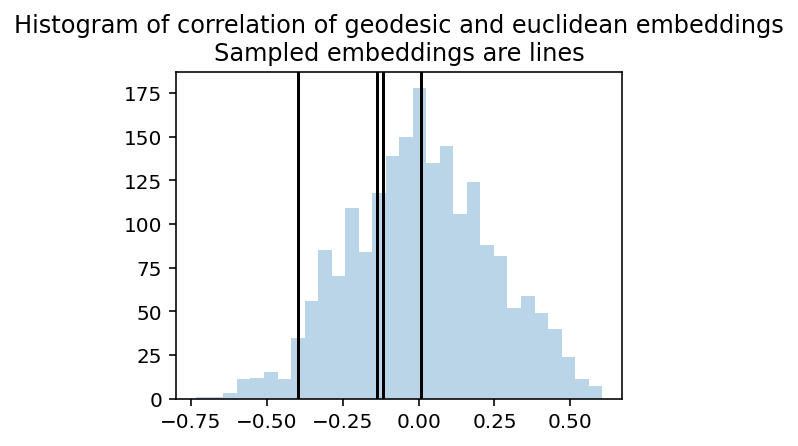

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 1->6 -->
 
 1->

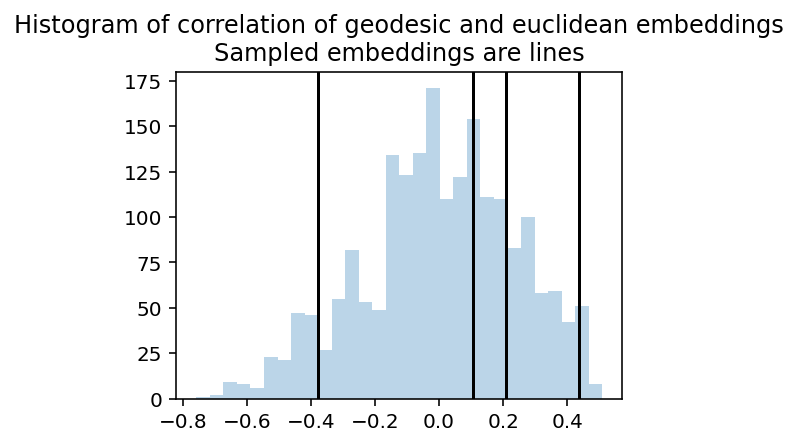

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 3->6 -->
 
 3->6

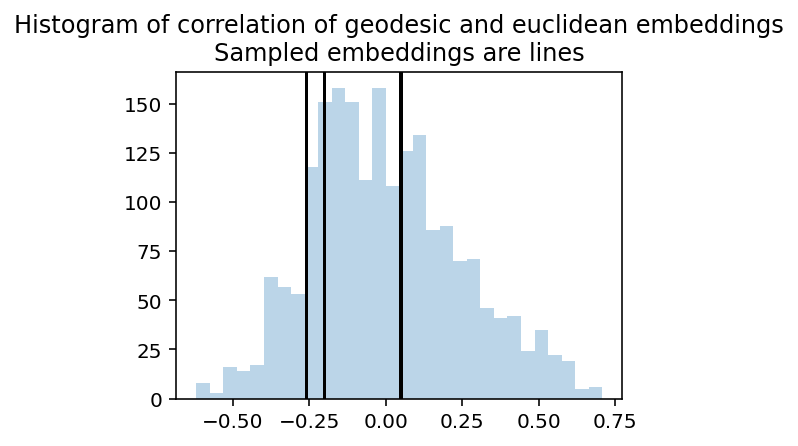

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->5 -->
 
 3->5

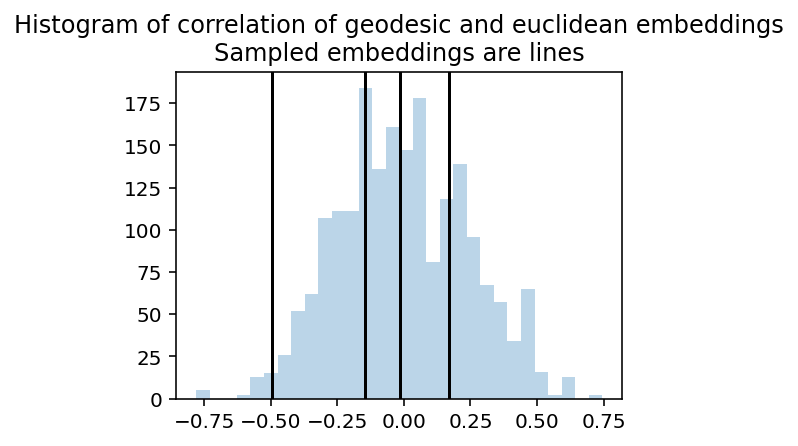

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 3->6 -->
 
 3->6

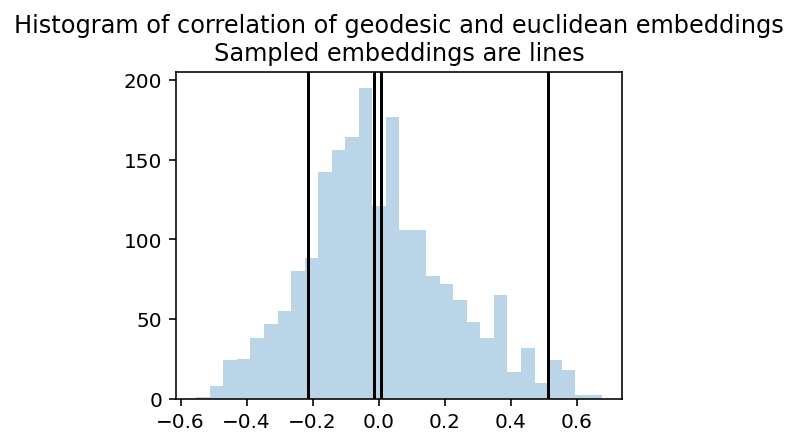

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->6 -->
 
 2->6

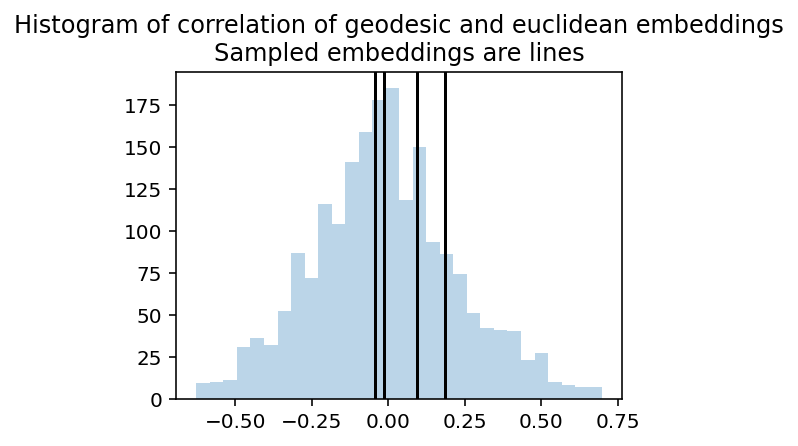

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->6 -->
 
 3->6

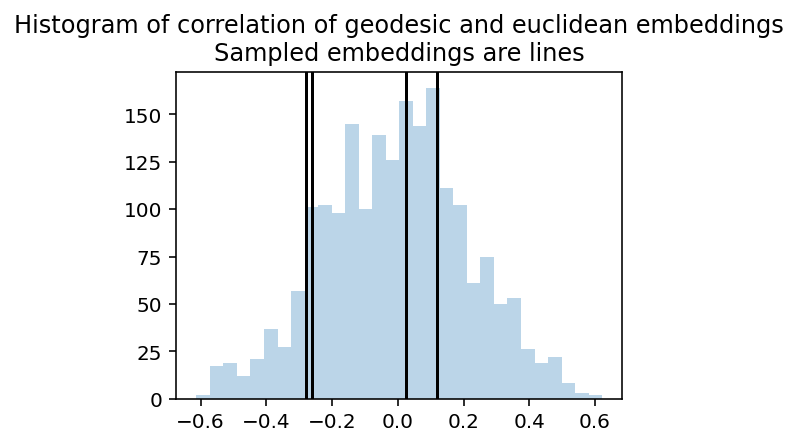

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6

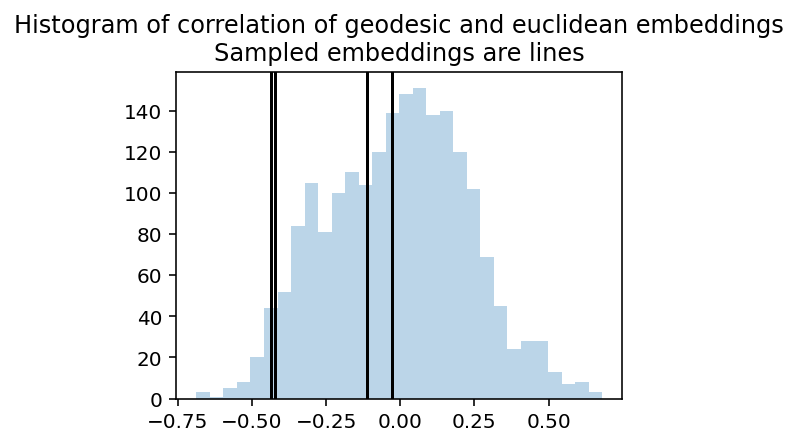

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7

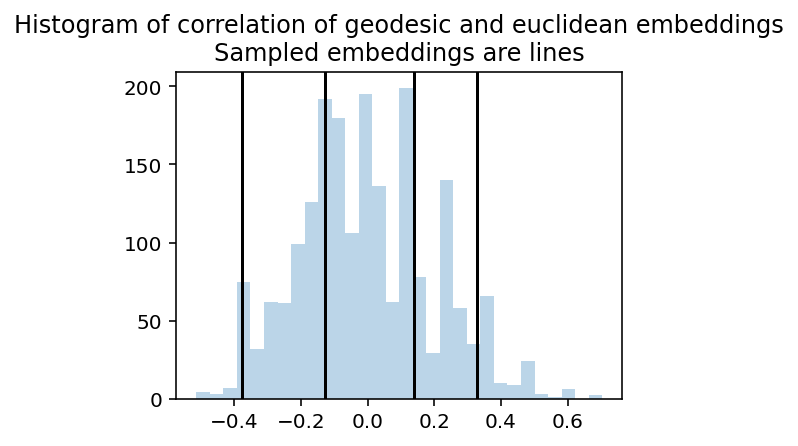

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 4->5 -->
 
 4->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 4->5 -->
 
 4->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 4->5 -->
 
 4->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 4->5 -->
 
 4->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 4->5 -->
 
 4->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6

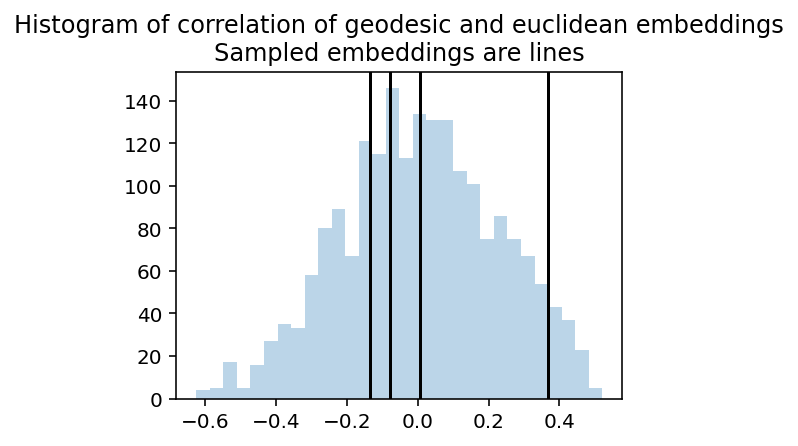

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7

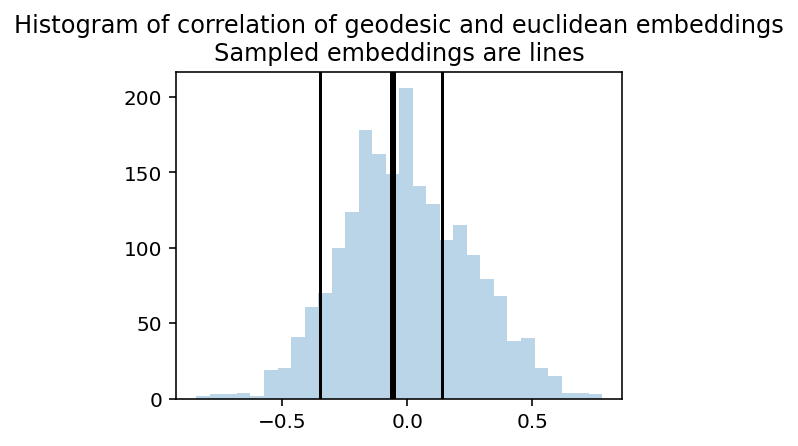

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6

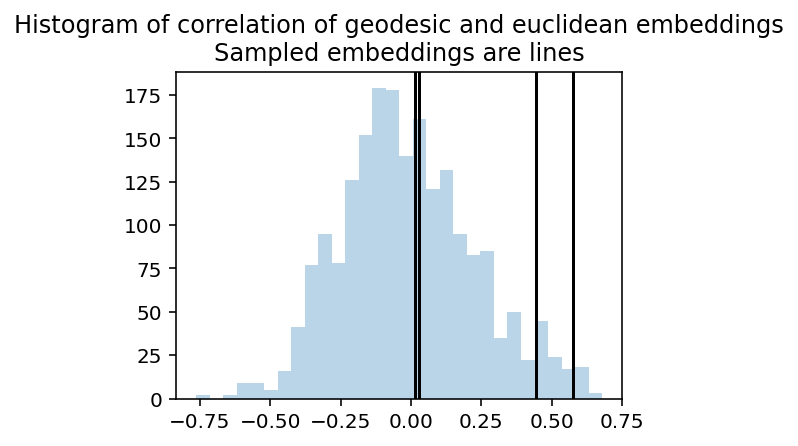

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7

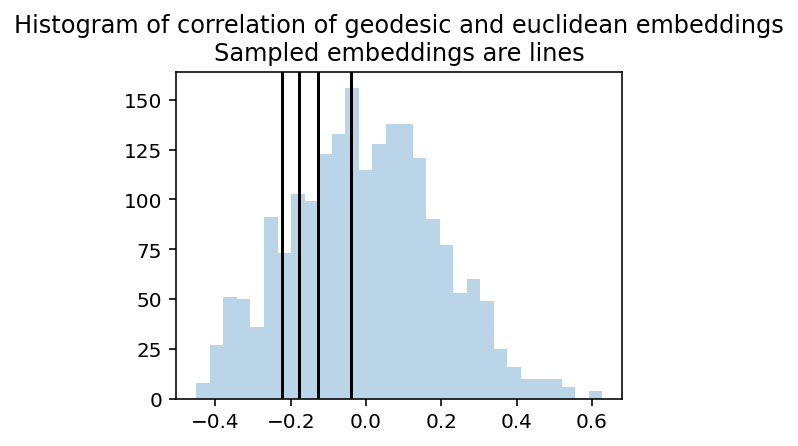

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->6 -->
 
 5->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->6 -->
 
 5->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->6 -->
 
 5->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->6 -->
 
 5->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 5->6 -->
 
 5->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 6->7 -->
 
 6->

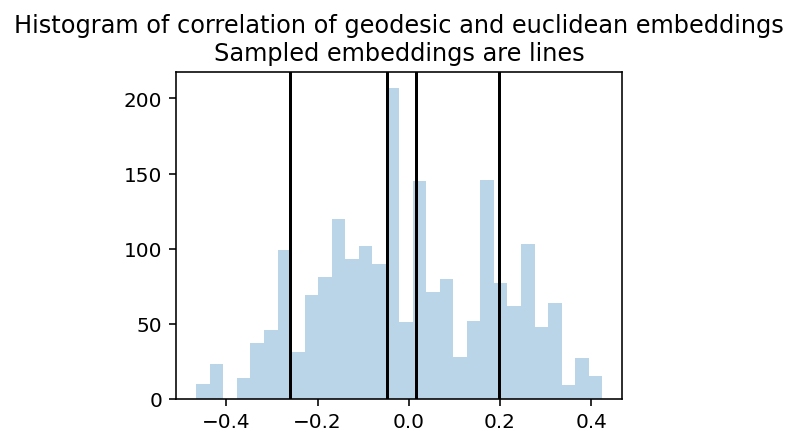

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->7 -->
 
 2->7

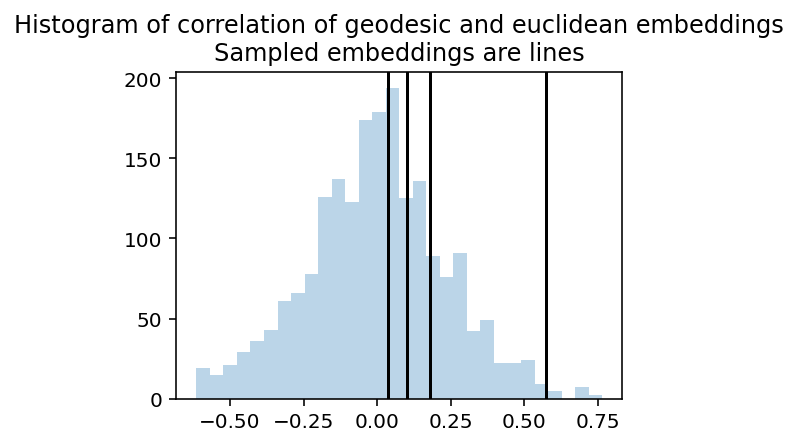

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6

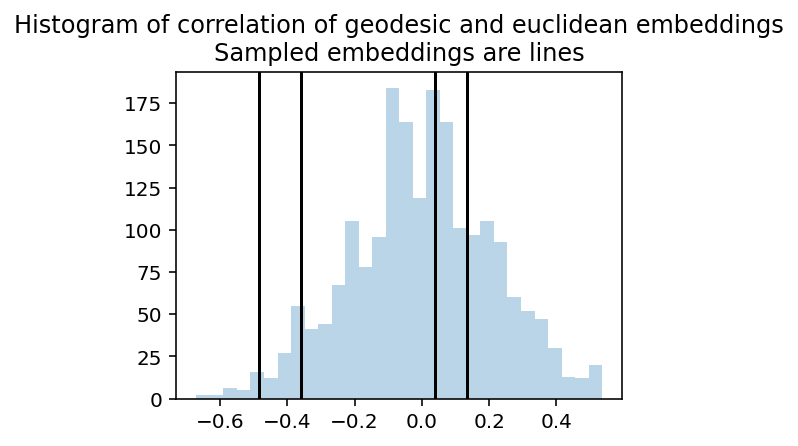

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->5 -->
 
 3->5 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->5 -->
 
 3->5

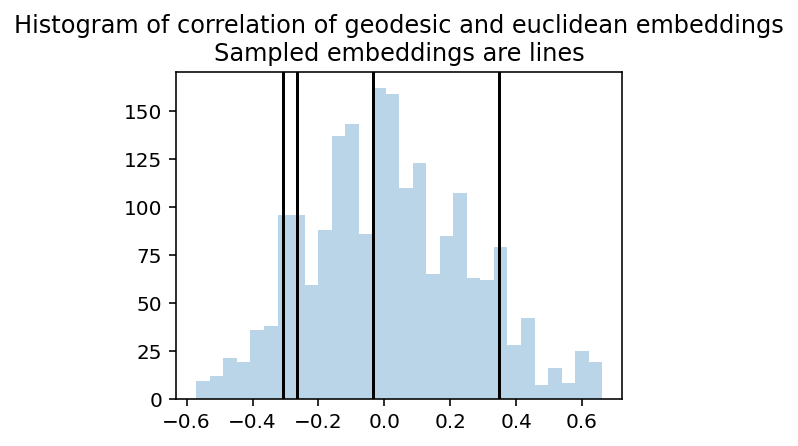

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->5 -->
 
 4->5 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->5 -->
 
 4->5 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->5 -->
 
 4->5 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->5 -->
 
 4->5 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->5 -->
 
 4->5 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6

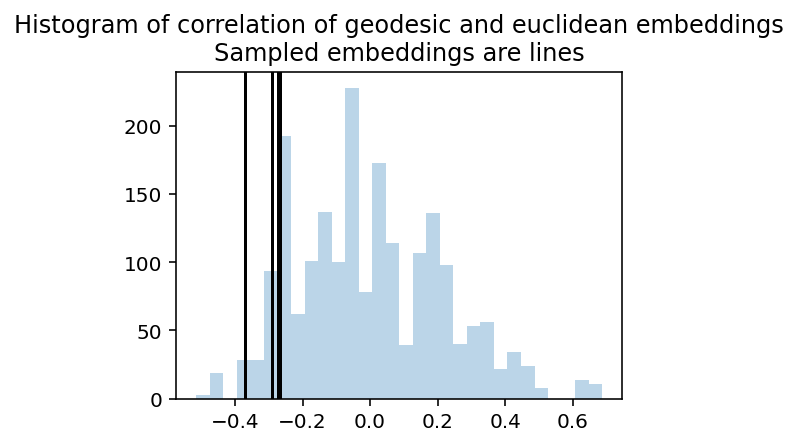

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6

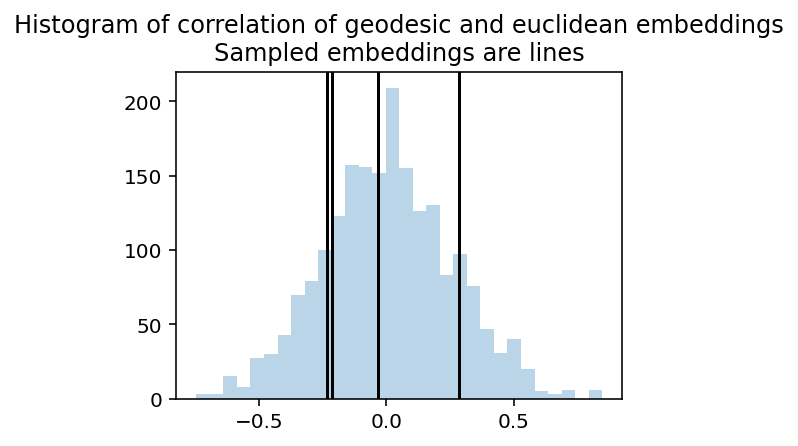

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->4 -->
 
 3->4 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 5->6 -->
 
 5->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->4 -->
 
 3->4 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 5->6 -->
 
 5->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->4 -->
 
 3->4 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 5->6 -->
 
 5->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->4 -->
 
 3->4 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 5->6 -->
 
 5->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 0->3 -->
 
 0->3 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 3->4 -->
 
 3->4 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 5->6 -->
 
 5->6 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->7 -->
 
 2->

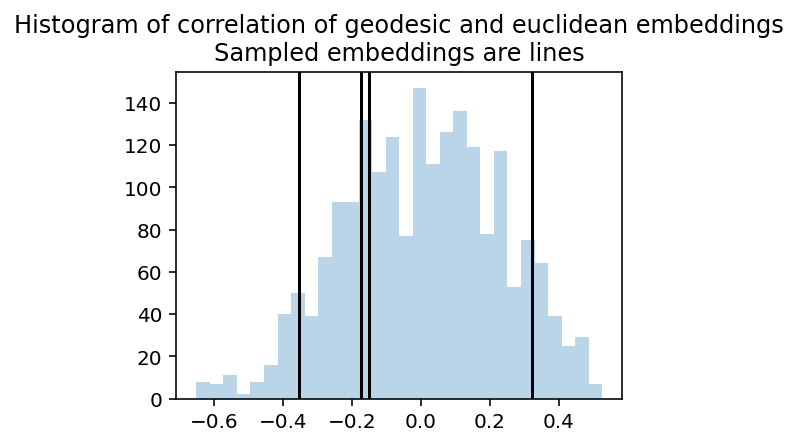

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 0->5 -->
 
 0->5 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->4 -->
 
 1->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6

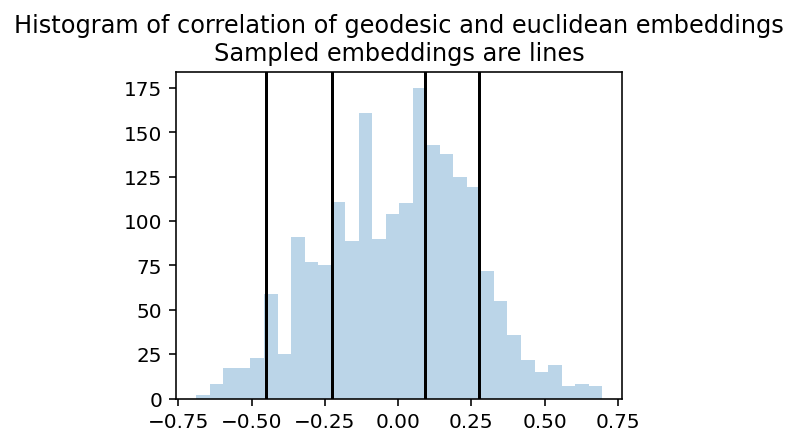

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 0->7 -->
 
 0->7 
 
 
<!-- 4->6 -->
 
 4->6 
 
 
<!-- 4->7 -->
 
 4->7 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->6 -->
 
 3->6

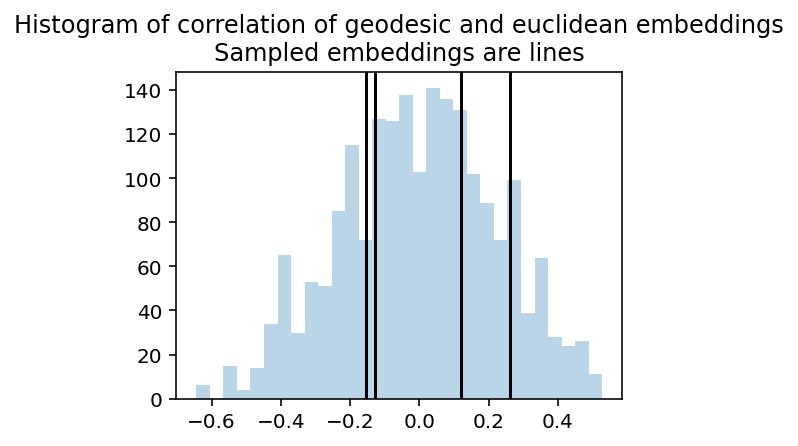

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7 
 
 
 
 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.1 (20210923.0004)
 -->
<!-- Pages: 1 -->
 
 
 
<!-- 0 -->
 
 0 
 
 
 
 
 
<!-- 4 -->
 
 4 
 
 
 
 
 
<!-- 0->4 -->
 
 0->4 
 
 
<!-- 6 -->
 
 6 
 
 
 
 
 
<!-- 0->6 -->
 
 0->6 
 
 
<!-- 7 -->
 
 7 
 
 
 
 
 
<!-- 6->7 -->
 
 6->7 
 
 
<!-- 1 -->
 
 1 
 
 
 
 
 
<!-- 1->6 -->
 
 1->6 
 
 
<!-- 5 -->
 
 5 
 
 
 
 
 
<!-- 1->5 -->
 
 1->5 
 
 
<!-- 1->7 -->
 
 1->7 
 
 
<!-- 5->7 -->
 
 5->7 
 
 
<!-- 2 -->
 
 2 
 
 
 
 
 
<!-- 2->6 -->
 
 2->6 
 
 
<!-- 2->5 -->
 
 2->5 
 
 
<!-- 2->7 -->
 
 2->7 
 
 
<!-- 3 -->
 
 3 
 
 
 
 
 
<!-- 3->7 -->
 
 3->7

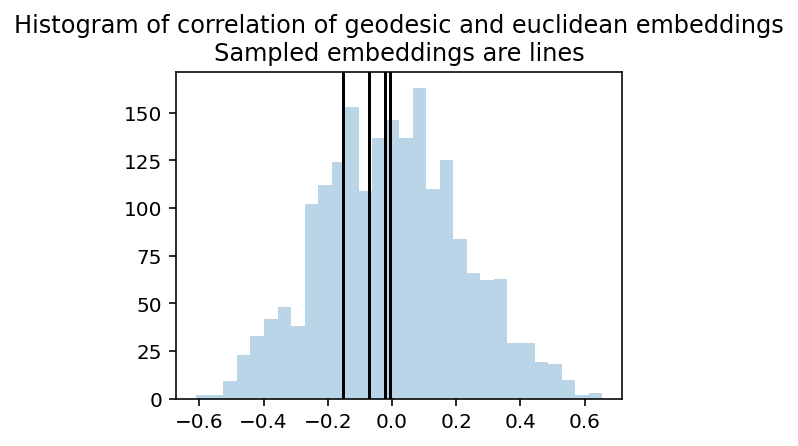

In [79]:
seed = random.randint(0, 2**30)
seed = 792828651
print('seed', seed)
rnd = random.Random(seed)

out = dict(
    generate_experiment_config_for_graphs(graph_list, random=rnd),
    seed=seed,
)
write_config(out)

for idx, mdp in enumerate(graph_list):
    poss = [generate.graphviz_coordinates(mdp, layout='neato')]+[
        embedding['coordinates'][0] # HACK picking arbitrary rotation
        for embedding in out['embedding']
    ]
    rrtd.display_graphs([rrtd.plot_graph(mdp, pos=p, constant_node_size=0.05) for p in poss], columns=len(poss))
    generate.plot_coordinates_relative_to_null(mdp, circle_orders=[e['order'] for e in out['embedding']])
    plt.show()
